# Setup | 设置

Latest Update: 05/15/2025

## Packages

In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

import json
import os
import sys

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

## Global Var

In [2]:
project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root_path not in sys.path:
    sys.path.append(project_root_path)

In [13]:
# temp_path = 'data/external/donglee_IOT_log_250507/'
input_superior_path = 'data/reframing/collection_sep_device_log/'
# input_superior_path2 = 'output/'
ouput_superior_path = 'output/'

## Modules

In [4]:
from utils.build_your_df_features import init_df_data_analysis
from toolbox.data_analyser import DataAnalyser

## Built-in Functions

In [5]:
def get_df_device_log(device_name, input_superior_path):
    file_path = os.path.join(project_root_path, input_superior_path, (str(device_name) + '.xlsx'))
    df_device_log = pd.read_excel(file_path)
    
    return df_device_log, file_path

In [6]:
# def get_your_df(input_superior_path, file_name):
#     file_path = os.path.join(project_root_path, input_superior_path, (str(file_name) + '.xlsx'))
#     df_data_analysis = pd.read_excel(file_path)

#     return df_data_analysis

In [11]:
def output_your_df(df_data_analysis, output_superior_path, file_name):
    file_path = os.path.join(project_root_path, output_superior_path, (str(file_name) + '.xlsx'))
    df_data_analysis.to_excel(file_path, index=False, engine='openpyxl')

    print(f"File saved to: {file_path}")

Attention: 以下 cell 仅需运行一次，数据集已创建。

In [10]:
def translate_your_df_column_names(df_data_analysis):
    df_data_analysis_translated = df_data_analysis.copy()

    # Rename columns to Chinese
    column_mapping = {
        'outbound_item': '出库项目',
        'device_code': '设备编号',
        'device_name': '设备名称',
        'log_len': '日志长度',
        'downtime': '下线日期 (或当前日志时间)',
        'uptime': '上线日期',
        'months_len': '使用月数 (包含中途离线)',
        'num_days_breaks': '设备离线次数',
        'max_days_break': '最大离线天数',
        'total_days_breaks': '总计离线天数',
        'months_len_exclude_breaks': '实际使用月数 (不含中途离线)',
        'continued_status': '连续性',
        'times_of_standby': '设备待机次数',
        'times_of_irrigation_start': '开启灌溉次数',
        'times_of_irrigation_close': '关闭灌溉次数',
        'times_of_uptime': '设备上线次数',
        'times_of_downtime': '设备下线次数',
        'times_of_strong_signal': '强信号次数',
        'times_of_mid_signal': '中等强度次数',
        'times_of_weak_signal': '弱强度次数',
        'times_of_null_signal': '无信号次数',
        'average_signal': '平均信号强度',
        'min_signal': '最小信号强度',
        'max_signal': '最大信号强度',
        'times_signal_switch_strong_mid': '强/中信号切换次数',
        'times_signal_switch_strong_weak': '强/弱信号切换次数',
        'times_signal_switch_strong_null': '强/无信号切换次数',
        'times_signal_switch_mid_weak': '中/弱信号切换次数',
        'times_signal_switch_mid_null': '中/无信号切换次数',
        'times_signal_switch_weak_null': '弱/无信号切换次数'
    }

    df_data_analysis_translated.rename(columns=column_mapping, inplace=True)

    # Rename 'haida' to '海大总部' in the '出库项目' column
    df_data_analysis_translated['出库项目'] = \
        df_data_analysis_translated['出库项目'].replace('haida', '海大总部')
    
    # Rename 'T/F' to '是/否' in the '连续性' column
    df_data_analysis_translated['连续性'] = \
        df_data_analysis_translated['连续性'].replace('T', '是').replace('F', '否')

    return df_data_analysis_translated

# Work Space | 工作区

## Data Loading | 数据载入

Latest Update: 05/08/2025

### Pre-Loading [冻结]

\>> 先把 `equipment_verification` 的数据导进来 (提取名字、便于数据映射测试)

In [27]:
# Read only the first three columns from the equipments_verification_mycopy_20250421.xlsx
# Note: equipments_verification_20250421 is not selected to read because of Garbled
df_equipments_verification = pd.read_excel(
    os.path.join(project_root_path, 
                 'data/external/equipments_verification_mycopy_20250421.xlsx'),
    usecols=[0,1,2]
)

# Rename columns to English names for better readability
df_equipments_verification.columns = [ 
    'outbound_item', 
    'device_code',
    'device_name'
]

# Replace specific values in 'outbound_item' column
df_equipments_verification['outbound_item'] = \
    df_equipments_verification['outbound_item'].replace({
    '海大总部': 'haida',
    '三一总部': 'sanyi', 
    '小城故事': 'small_town'
})

In [28]:
df_equipments_verification.shape

(229, 3)

In [ ]:
### Mapping Test [冻结]

\>> 数据映射测试——尤其是针对于0507发放的海大项目日志数据

In [29]:
df_devices_temp1 = \
    df_equipments_verification[df_equipments_verification['outbound_item'] == 'haida']

df_devices_temp2 = df_equipments_verification.copy()

df_devices_temp3 = df_equipments_verification.iloc[:-1].copy()

for i, df_devices_temp in enumerate([df_devices_temp1, df_devices_temp2, df_devices_temp3]):
    if i == 0:
        print("HaiDa Item [海大项目]")
        print("-"*30)
    if i == 1:
        print("\nAll Outbound Item [所有项目]")
        print("-"*30)
    if i == 2:
        print("\nHaiDa Item Except for the Last First Line [海大项目 (除去唯一无名行)]")
        print("-"*30)

    # Extract filenames - fixed the list nesting issue
    filenames_temp = [os.path.splitext(f)[0] for f in os.listdir(path_superior1) 
                    if f.endswith('.xlsx') or f.endswith('.xls')]

    # Check bijective relationship
    devices_names_set = set(df_devices_temp['device_name'].dropna())
    filenames_set = set(filenames_temp)

    print(f"Total device names [所有设备名称 (数量)]: {len(devices_names_set)}")
    print(f"Total excel files [所有 excel 文件 (数量)]: {len(filenames_set)}")
    print_temp1 = len(devices_names_set.intersection(filenames_set))
    print(f"Intersection [取交集]: {print_temp1}")
    print_temp2 = len(devices_names_set - filenames_set)
    print(
        f"Device names not found in excel files [匹配不到的设备名称 (数量)]: {print_temp2}"
    )
    print_temp3 = len(filenames_set - devices_names_set)
    print(
        f"Excel files not matching any device name [匹配不到的excel 文件 (数量)]: {print_temp3}"
    )

    # If the sets are equal in size and their intersection equals either set, 
    # they are bijective
    is_bijective = \
        (len(devices_names_set) == len(filenames_set) and 
        len(devices_names_set.intersection(filenames_set)) == len(devices_names_set))
    print(f"Is the relationship bijective [互为双射关系]? {is_bijective}")

HaiDa Item [海大项目]
------------------------------
Total device names [所有设备名称 (数量)]: 110
Total excel files [所有 excel 文件 (数量)]: 211
Intersection [取交集]: 110
Device names not found in excel files [匹配不到的设备名称 (数量)]: 0
Excel files not matching any device name [匹配不到的excel 文件 (数量)]: 101
Is the relationship bijective [互为双射关系]? False

All Outbound Item [所有项目]
------------------------------
Total device names [所有设备名称 (数量)]: 211
Total excel files [所有 excel 文件 (数量)]: 211
Intersection [取交集]: 210
Device names not found in excel files [匹配不到的设备名称 (数量)]: 1
Excel files not matching any device name [匹配不到的excel 文件 (数量)]: 1
Is the relationship bijective [互为双射关系]? False

HaiDa Item Except for the Last First Line [海大项目 (除去唯一无名行)]
------------------------------
Total device names [所有设备名称 (数量)]: 211
Total excel files [所有 excel 文件 (数量)]: 211
Intersection [取交集]: 210
Device names not found in excel files [匹配不到的设备名称 (数量)]: 1
Excel files not matching any device name [匹配不到的excel 文件 (数量)]: 1
Is the relationship bijectiv

Note Above：第三轮遍历说明 `equipments_verification` 除不除去无名行对上述检验是没有影响的。

In [34]:
df_devices_temp4 = df_equipments_verification.copy()

for i, df_devices_temp in enumerate([df_devices_temp4]):
    print("\nAll Outbound Item [所有项目]")
    print("-"*30)

    # Extract filenames - fixed the list nesting issue
    filenames_temp = [os.path.splitext(f)[0] for f in os.listdir(path_superior1) 
                    if f.endswith('.xlsx') or f.endswith('.xls')]

    # Check bijective relationship
    devices_names_set = set(df_devices_temp['device_name'].dropna())
    filenames_set = set(filenames_temp)

    print(f"Total device names [所有设备名称 (数量)]: {len(devices_names_set)}")
    print(f"Total excel files [所有 excel 文件 (数量)]: {len(filenames_set)}") 
    print_temp1 = len(devices_names_set.intersection(filenames_set))
    print(f"Intersection [取交集]: {print_temp1}")
    
    # Print device names not found in excel files
    print_temp2 = len(devices_names_set - filenames_set)
    print(f"Device names not found in excel files [匹配不到的设备名称 (数量)]: {print_temp2}")
    if print_temp2 > 0:
        print("List of device names not found in excel files ")
        print("[在当前 excel 文件中匹配不到的设备名称]:")
        for device_name in sorted(devices_names_set - filenames_set):
            print(f"  - {device_name}")
    
    # Print excel files not matching any device name
    print_temp3 = len(filenames_set - devices_names_set)
    print(f"Excel files not matching any device name [匹配不到的excel 文件 (数量)]: {print_temp3}")
    if print_temp3 > 0:
        print("List of excel files not matching any device name ")
        print("[在当前设备名称中匹配不到的 excel 文件]:")
        for filename in sorted(filenames_set - devices_names_set):
            print(f"  - {filename}")


All Outbound Item [所有项目]
------------------------------
Total device names [所有设备名称 (数量)]: 211
Total excel files [所有 excel 文件 (数量)]: 211
Intersection [取交集]: 210
Device names not found in excel files [匹配不到的设备名称 (数量)]: 1
List of device names not found in excel files 
[在当前 excel 文件中匹配不到的设备名称]:
  - QXZL00000208
Excel files not matching any device name [匹配不到的excel 文件 (数量)]: 1
List of excel files not matching any device name 
[在当前设备名称中匹配不到的 excel 文件]:
  - l6idYDXlfYkXKgegFwG


Note Above: 
- 匹配不到的设备 `QXZL00000208` 在原有文件中本身是缺乏 IMEI 和 互联网卡号的
- 匹配不到的 excel `l6idYDXlfYkXKgegFwG` 疑似命名错误——缺乏一个后缀，因为存在另一个内容完全相同的 excel `l6idYDXlfYkXKgegFwGW`

### Duplication Test [冻结]

\>> 重复性/冗余性测试

回顾上述的输出结果：
- 所有不重复的设备名称 (数量)：211，除去一个缺乏 IMEI 的设备，最后应记为 210
- 所有不重复的 excel 文件 (数量)：211，除去一个疑似命名错误的文件，最后应记为 210

即便如此，实际上在不同的出库项目中，设备的名称还存在重复使用的情况：

In [56]:
print(f"[设备检查表 (海大项目) 所记录的总行数: {len(df_devices_temp1)}]")
print(f"The total rows recorded in `equipments_verification` (haida): {len(df_devices_temp1)}")
print()
print(f"[设备检查表所记录的总行数: {len(df_devices_temp2)}]")
print(f"The total rows recorded in `equipments_verification`: {len(df_devices_temp2)}")

[设备检查表 (海大项目) 所记录的总行数: 110]
The total rows recorded in `equipments_verification` (haida): 110

[设备检查表所记录的总行数: 229]
The total rows recorded in `equipments_verification`: 229


In [58]:
# Check for duplicate device names in the verification list
duplicate_devices_temp = df_equipments_verification['device_name'].duplicated().sum()
print(f"[在 `equipments_verification` 中，有以下设备名称出现了重复：{duplicate_devices_temp}]")
print(f"Duplicate device names in verification list: {duplicate_devices_temp}")

# Display devices with duplicate names
if duplicate_devices_temp > 0:
    print("\n[罗列所有重复的设备名称：]")
    print("Devices with duplicate names:")
    duplicate_device_names_temp = \
        df_equipments_verification[df_equipments_verification['device_name'].duplicated(keep=False)]
    
    duplicate_device_names_temp = duplicate_device_names_temp.copy()
    duplicate_device_names_temp.loc[:, 'outbound_item'] = duplicate_device_names_temp['outbound_item'].replace({
        'haida': '海大总部',
        'sanyi': '三一总部',
        'small_town': '小城故事'
    })
    display(duplicate_device_names_temp.sort_values('device_name'))
    display(duplicate_device_names_temp.shape)

# Check for null device names
null_device_names = df_equipments_verification['device_name'].isna().sum()
print(f"\n[在 `equipments_verification` 中，有以下设备名称是空值：{null_device_names}]")
print(f"Null device names in verification list: {null_device_names}")
if null_device_names > 0:
    print("\n[罗列所有空值的设备名称：]")
    print("Rows with null device names:")
    df_equipments_verification_temp = df_equipments_verification.copy()
    df_equipments_verification_temp.loc[:, 'outbound_item'] = df_equipments_verification_temp['outbound_item'].replace({
        'haida': '海大总部',
        'sanyi': '三一总部',
        'small_town': '小城故事'
    })
    display(df_equipments_verification_temp[df_equipments_verification_temp['device_name'].isna()])

[在 `equipments_verification` 中，有以下设备名称出现了重复：17]
Duplicate device names in verification list: 17

[罗列所有重复的设备名称：]
Devices with duplicate names:


,outbound_item,device_code,device_name
224,小城故事,备用,1Cfkt6apBtAXwjohGlpe
115,三一总部,3,1Cfkt6apBtAXwjohGlpe
116,三一总部,3,5nWolPHobAnA3Pw8Fo84
212,小城故事,20,5nWolPHobAnA3Pw8Fo84
165,三一总部,26,9BuWUWHkIwEkBARB6rJy
79,海大总部,43,9BuWUWHkIwEkBARB6rJy
207,小城故事,17,EEsoF20PPvXNg3EMrZDQ
61,海大总部,33,EEsoF20PPvXNg3EMrZDQ
189,小城故事,2,Hyw9taUy0cwwm5UxyaUX
48,海大总部,26,Hyw9taUy0cwwm5UxyaUX


(34, 3)


[在 `equipments_verification` 中，有以下设备名称是空值：1]
Null device names in verification list: 1

[罗列所有空值的设备名称：]
Rows with null device names:


,outbound_item,device_code,device_name
228,小城故事,备用,NaN


### Data Reframing [冻结]

\>> (在完成数据映射测试后) 进行数据载入处理

以遍历 `equipments_verification` 的设备条目为标准，定位到 `haida/sanyi/small_town` (尽管小城的我现在做不了) 之一的划分桶后，（在确认满足单射的情况下）搜索 `donglee_iot_log` 对应的设备日志条目，新建和整合数据。

Attention: 以下 cell 仅需运行一次，数据集已创建。

In [9]:
# flag = True

for index, row in df_equipments_verification.iterrows():
    outbound_item = row['outbound_item']
    device_name = row['device_name']

    # Skip sanyi and small_town data due to duplication issues identified in earlier tests
    if str(outbound_item) == 'haida': 
        # Check if device_name is not null before proceeding
        if pd.notna(device_name):
            try:
                path_read1 = path_superior1 + str(device_name) + '.xlsx'
                path_write1 = path_superior2 + str(outbound_item) + '/'
                
                # # Ensure the output directory exists
                # os.makedirs(path_write1, exist_ok=True)

                # Read the xlsx file for the current device
                df_device_log = pd.read_excel(
                    path_read1,
                    usecols=['创建时间', '电量', '信号', '操作类型']
                )
                df_device_log.columns = [
                    'create_time',
                    'battery_level',
                    'signal_strength',
                    'operation'
                ]
                
                # Export the dataframe to excel format in the destination path
                path_write2 = os.path.join(path_write1, f"{device_name}.xlsx")
                df_device_log.to_excel(
                    path_write2, index=False, 
                    engine='openpyxl', 
                    # options={'default_style': True}
                )
                
                print(f"Processed device: {device_name} for {outbound_item}")
            except Exception as e:
                print(f"Error processing device {device_name}: {str(e)}")
        else:
            print(f"Skipping row {index} - device_name is null")

        # if flag is True:
        #     break

Processed device: r24zIcmdHvbIjmkUZ1F6 for haida
Processed device: Z6ComQVQfeeFXVILZi6r for haida
Processed device: i3wXOxXUJcCs6Yvzmomf for haida
Processed device: yhbrF68hTLzS4qnz97M4 for haida
Processed device: Xm0AmTM2HZlwzhTiTpa3 for haida
Processed device: 1r8icbIlgm58wBY5zfVR for haida
Processed device: ZklyyqoWjdBszJvpUfYf for haida
Processed device: f17TwRpnsc5HRZCMttco for haida
Processed device: 5vb6AoplSC70yotYZ3yn for haida
Processed device: Hxf6VLLe1gHjqoHLphWf for haida
Processed device: g0xHvUq5byNR391HqnQj for haida
Processed device: fqEF25kBkroIKXGNYMj8 for haida
Processed device: VgbbFRm3aKyLx45L0ozY for haida
Processed device: 74r4RE1NhUao7F9IIqFF for haida
Processed device: sHLUV8Rj83i88rpnFYpi for haida
Processed device: bjZD21GVvZy1Q45Vq8yD for haida
Processed device: bGzTvuJFAhiXWCuY93tK for haida
Processed device: XKS05cSkwCwdFtKCEc8o for haida
Processed device: WhhQxm2lUlKDwlyzRwsj for haida
Processed device: dQkkEvvJE2qJJ0QgRcBl for haida
Processed device: gV

## Project-Based Integration | 基于项目整合

### Features Building

\>> 基于 `equipments_verification` 建表 (初始限制范围海大)

Latest Update: 05/19/2025

Attention: 所有的 `feature` 根据雇主的需求和偏好调整

In [6]:
# Create a dataframe for data analysis (HaiDa temporarily)
df_data_analysis = init_df_data_analysis(haida=True, sanyi=False, small_town=False)
display(df_data_analysis)

,outbound_item,device_code,device_name,log_len,downtime,uptime,months_len,num_days_breaks,max_days_break,total_days_breaks,...,times_of_null_signal,average_signal,min_signal,max_signal,times_signal_switch_strong_mid,times_signal_switch_strong_weak,times_signal_switch_strong_null,times_signal_switch_mid_weak,times_signal_switch_mid_null,times_signal_switch_weak_null
0,haida,1,r24zIcmdHvbIjmkUZ1F6,0,NaT,NaT,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
1,haida,2,Z6ComQVQfeeFXVILZi6r,0,NaT,NaT,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2,haida,2,i3wXOxXUJcCs6Yvzmomf,0,NaT,NaT,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
3,haida,3,yhbrF68hTLzS4qnz97M4,0,NaT,NaT,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
4,haida,3,Xm0AmTM2HZlwzhTiTpa3,0,NaT,NaT,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,haida,61,shTs33zYjNaDuwqTjIjI,0,NaT,NaT,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
106,haida,62,eDPDaKrigKnjKFGAdc40,0,NaT,NaT,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
107,haida,63,oObcfR8y7UcjQBj5uomd,0,NaT,NaT,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
108,haida,64,Lhu8ErPaZ9E5oqY1EYrv,0,NaT,NaT,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


Note Forward: 第二个要建的表就应该是每个月份使用时长下，各个类别的参数关系

In [ ]:
# df_data_analysis2 = func()
# display(df_data_analysis2)

### Data Processing

\>> 对每个设备的日志数据进行处理，以统计必要的特征。

Latest Update: 05/19/2025

In [7]:
# Reassign the input path (HaiDa temporarily)
input_superior_path = os.path.join(input_superior_path, 'haida')
data_analyser = DataAnalyser(df_data_analysis=df_data_analysis)

In [8]:
for index, row in df_data_analysis.iterrows():
    try:
        device_name = row['device_name']
        df_device_log, file_path = get_df_device_log(device_name, input_superior_path)

    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")

    ### Implement data processing logic for each device log
    ### 施行对于每个灌溉设备日志数据的处理逻辑
    data_analyser.identify_id_info(device_name=device_name, df_device_log=df_device_log)

    # Update log length
    # 记录日志的长度 (便于对频次型指标进行划归)
    data_analyser.get_log_len()

    # Update downtime and uptime
    # 更新下线时间与上线时间
    data_analyser.get_downtime_uptime()

    # Simply calculate the life-cycle in months
    # 简单地计算设备的使用生命周期 (下线时间与上线时间之差)
    data_analyser.get_month_len_include_break()

    # Calculate the life-cycle with consideration of day-break events
    # 考虑在设备的整个生命周期内，是否出现显著的日志间断现象，以计算实际的使用生命周期
    data_analyser.get_month_len_exclude_break(
        days_break_threshold=2, 
        threshold_days_for_excluding=30
    )

    # Mark the log characteristic as 'Not continued' if maximal broken days over the threshold
    # 如果最大间隔天数超过设定阈值，标记该设备的日志属性为 “不连续”
    data_analyser.get_continued_status(broken_down_threshold=15)

    # Count the frequency of the five operation status recorded in the log over the life-cycle 
    # 统计日志记录中五种操作状态 (灌溉开启/灌溉关闭/上线/离线/待机) 在设备生命周期内出现的频次
    data_analyser.get_operation_status()

    # Count the frequency of the four categorizes of signal strength (strong/mid/weak/null)
    # recorded in the log over the life-cycle
    # 统计日志记录中四种信号强度 (强信号/中信号/弱信号/无信号) 在设备生命周期内出现的频次 
    data_analyser.get_signal_strength_frequency()

    # Count the frequency of the cases in which a device went through significant signal switches
    # 统计日志记录中 (相邻的两个时间戳下) 设备显著切换信号强度的频次
    data_analyser.get_signal_switch_frequency(window_len=2) 

In [9]:
data_analyser._df_data_analysis.head(5)

,outbound_item,device_code,device_name,log_len,downtime,uptime,months_len,num_days_breaks,max_days_break,total_days_breaks,...,times_of_null_signal,average_signal,min_signal,max_signal,times_signal_switch_strong_mid,times_signal_switch_strong_weak,times_signal_switch_strong_null,times_signal_switch_mid_weak,times_signal_switch_mid_null,times_signal_switch_weak_null
0,haida,1,r24zIcmdHvbIjmkUZ1F6,4240,2025-05-07,2024-11-05,6,1,2,2,...,12,20.18,0,31,199,4,1,76,0,9
1,haida,2,Z6ComQVQfeeFXVILZi6r,4796,2025-04-29,2024-10-31,6,1,2,2,...,3,20.19,0,31,292,15,0,251,0,0
2,haida,2,i3wXOxXUJcCs6Yvzmomf,2001,2025-05-07,2024-10-11,6,4,123,131,...,1,20.17,1,29,217,3,0,46,0,2
3,haida,3,yhbrF68hTLzS4qnz97M4,4226,2025-04-17,2024-10-31,5,1,2,2,...,2,25.49,0,31,120,2,0,6,0,0
4,haida,3,Xm0AmTM2HZlwzhTiTpa3,5438,2025-03-12,2024-08-30,6,1,72,72,...,1,18.02,1,29,509,1,0,214,1,1


In [14]:
df_data_analysis_updated = data_analyser._df_data_analysis
df_data_analysis_updated_translated = translate_your_df_column_names(df_data_analysis_updated)

file_name1 = 'data_analysis_general_log_stat_haida_250515'
file_name2 = '基于日记250507-海大设备数据分析-250515'

output_your_df(df_data_analysis_updated, ouput_superior_path, file_name1)
output_your_df(df_data_analysis_updated_translated, ouput_superior_path, file_name2)

File saved to: d:\project_code\project_donglee_intern\output/data_analysis_general_log_stat_haida_250515.xlsx
File saved to: d:\project_code\project_donglee_intern\output/基于日记250507-海大设备数据分析-250515.xlsx


# Discard [Temp] | 丢弃 [临时]

## IOT Log

In [ ]:
# path = ' '
# df = pd.read_excel(path + 'donglee_IOT_log_250424.xlsx')

df_donglee_IOT_log = pd.read_excel('donglee_IOT_log_250424.xlsx')

# Drop the second to last column (100% '1'; appearing to be a fixed mark)
df_donglee_IOT_log = df_donglee_IOT_log.drop(df_donglee_IOT_log.columns[-2], axis=1)

# Rename columns to English names for better readability
df_donglee_IOT_log.columns = [
    'id', 
    'create_time',
    'imei',
    'iccid',
    'activation_time', 
    'device_name',
    'battery_level',
    'signal_strength',
    'content',
    # 'status_code',
    'operation'
]

df_donglee_IOT_log.head(15)

,id,create_time,imei,iccid,activation_time,device_name,battery_level,signal_strength,content,operation
0,491452,2025-04-22 16:19:33,865118070276948,898608131023C0031849,2025-04-08 20:08:02,l6idYDXlfYkXKgegFwGW,NaN,NaN,"{""lastTime"":""2025-04-22 16:19:32.552"",""iotId"":...",设备上线
1,491451,2025-04-22 16:19:33,865118070276948,898608131023C0031849,2025-04-08 20:08:02,l6idYDXlfYkXKgegFwGW,NaN,NaN,"{""lastTime"":""2025-04-22 16:19:32.551"",""iotId"":...",设备下线
2,491447,2025-04-22 16:17:24,865118070111145,898608131023C0031353,2025-04-01 15:54:44,xAaxsmCd3YLtGdAw0thB,NaN,NaN,"{""lastTime"":""2025-04-22 16:17:24.166"",""iotId"":...",设备下线
3,491446,2025-04-22 16:16:51,865118070276948,898608131023C0031849,2025-04-08 20:08:02,l6idYDXlfYkXKgegFwGW,NaN,NaN,"{""lastTime"":""2025-04-22 16:16:50.474"",""iotId"":...",设备上线
4,491442,2025-04-22 16:14:38,865118070199140,898608131023C0031330,2025-04-01 15:51:24,M0oVoNDM9YSxlDwTzRVy,NaN,NaN,"{""lastTime"":""2025-04-22 16:14:37.753"",""iotId"":...",设备上线
5,491441,2025-04-22 16:14:37,865118070132778,898608131023C0031337,2025-04-15 09:45:36,UzgKUdfNznGuozsi8YhA,NaN,NaN,"{""lastTime"":""2025-04-22 16:14:37.329"",""iotId"":...",设备上线
6,491439,2025-04-22 16:14:12,865118070132778,898608131023C0031337,2025-04-15 09:45:36,UzgKUdfNznGuozsi8YhA,NaN,NaN,"{""lastTime"":""2025-04-22 16:14:11.924"",""iotId"":...",设备下线
7,491430,2025-04-22 16:12:38,865118070110758,898608131023C0031344,2025-04-15 11:23:12,EEsoF20PPvXNg3EMrZDQ,NaN,NaN,"{""lastTime"":""2025-04-22 16:12:37.638"",""iotId"":...",设备下线
8,491427,2025-04-22 16:11:36,867960060382782,898608131023C0031839,2025-04-15 10:53:27,mFRv1LyiaHZDQVnHwnxY,NaN,NaN,"{""lastTime"":""2025-04-22 16:11:35.812"",""iotId"":...",设备上线
9,491426,2025-04-22 16:11:27,867960060382782,898608131023C0031839,2025-04-15 10:53:27,mFRv1LyiaHZDQVnHwnxY,NaN,NaN,"{""lastTime"":""2025-04-22 16:11:26.999"",""iotId"":...",设备下线


## Single-Instance Test

### Value Selection

In [ ]:
testing_device = df_equipments_verification['device_name'].iloc[15]
print(f"First device name: {testing_device}")

First device name: bjZD21GVvZy1Q45Vq8yD


In [ ]:
# Filter df_donglee_IOT_log for records matching testing_device
df_donglee_IOT_log_id_matching = \
df_donglee_IOT_log[df_donglee_IOT_log['device_name'] == testing_device]

df_donglee_IOT_log_id_matching

,id,create_time,imei,iccid,activation_time,device_name,battery_level,signal_strength,content,operation
3300,478813,2025-04-19 14:29:02,865118070035211,898608131023C0031882,2025-04-15 11:15:59,bjZD21GVvZy1Q45Vq8yD,NaN,NaN,"{""lastTime"":""2025-04-19 14:29:02.219"",""iotId"":...",设备上线
3305,478810,2025-04-19 14:28:53,865118070035211,898608131023C0031882,2025-04-15 11:15:59,bjZD21GVvZy1Q45Vq8yD,NaN,NaN,"{""lastTime"":""2025-04-19 14:28:53.023"",""iotId"":...",设备下线
3347,478620,2025-04-19 13:19:24,865118070035211,898608131023C0031882,2025-04-15 11:15:59,bjZD21GVvZy1Q45Vq8yD,NaN,NaN,"{""lastTime"":""2025-04-19 13:19:23.658"",""iotId"":...",设备上线
3351,478617,2025-04-19 13:17:18,865118070035211,898608131023C0031882,2025-04-15 11:15:59,bjZD21GVvZy1Q45Vq8yD,NaN,NaN,"{""lastTime"":""2025-04-19 13:17:17.681"",""iotId"":...",设备下线
4162,474808,2025-04-18 12:27:21,865118070035211,898608131023C0031882,2025-04-15 11:15:59,bjZD21GVvZy1Q45Vq8yD,NaN,NaN,"{""lastTime"":""2025-04-18 12:27:21.114"",""iotId"":...",设备上线
...,...,...,...,...,...,...,...,...,...,...
248409,219232,2025-02-25 17:46:16,865118070035211,898608131023C0031882,2025-04-15 11:15:59,bjZD21GVvZy1Q45Vq8yD,95.0,NaN,"{""id_token"":""1740476783"",""imei"":""8651180700352...",开启灌溉
248417,219216,2025-02-25 17:43:06,865118070035211,898608131023C0031882,2025-04-15 11:15:59,bjZD21GVvZy1Q45Vq8yD,98.0,NaN,"{""id_token"":""1740476550"",""imei"":""8651180700352...",关闭灌溉
248430,219191,2025-02-25 17:37:35,865118070035211,898608131023C0031882,2025-04-15 11:15:59,bjZD21GVvZy1Q45Vq8yD,98.0,NaN,"{""id_token"":""1740476249"",""imei"":""8651180700352...",开启灌溉
248501,219065,2025-02-25 17:12:41,865118070035211,898608131023C0031882,2025-04-15 11:15:59,bjZD21GVvZy1Q45Vq8yD,92.0,15.0,"{""imei"":""865118070035211"",""iccid"":""89860813102...",设备状态


### Working Length

In [ ]:
# # Get the latest date from 'create_time' column
# latest_date = df_donglee_IOT_log['create_time'].max().date()
# print(f"Latest date in records: {latest_date}")

Latest date in records: 2025-04-22


In [ ]:
# Define downtime (or current time if normal functionality) and uptime
downtime = df_donglee_IOT_log_id_matching['create_time'].iloc[0].date()
uptime = df_donglee_IOT_log_id_matching['create_time'].iloc[-1].date()

# Calculate months length only if the gap between downtime and latest_date is larger than 3 days
flag_downtime = abs((downtime - latest_date).days)

if flag_downtime > 3:
    days_len = abs((downtime - uptime).days)
    months_len = days_len // 30
    print(f"Continue: Months length: {months_len}")
else:
    print("Stop: Gap between downtime and latest date is not larger than 3 days")

Continue: Months length: 5


In [ ]:
# Sort the dataframe by create_time to ensure chronological order
df_sorted = df_donglee_IOT_log_id_matching.sort_values('create_time')

# Calculate the time difference between consecutive records
df_sorted['time_diff'] = df_sorted['create_time'].diff()

# Find gaps larger than 3 days (72 hours)
large_gaps = df_sorted[df_sorted['time_diff'] > pd.Timedelta(days=3)]

if len(large_gaps) > 0:
    print(f"Found {len(large_gaps)} time breaks larger than 3 days:")
    for idx, row in large_gaps.iterrows():
        previous_date = row['create_time'] - row['time_diff']
        print(
            f"Gap of {row['time_diff'].days} days between "
            f"{previous_date.date()} and {row['create_time'].date()}"
        )
else:
    print("No time breaks larger than 3 days found")

Found 1 time breaks larger than 3 days:
Gap of 6 days between 2024-12-31 and 2025-01-06


### Unique Values Analysis

#### Operation, Battery, and Signals (Presentation)

**单例测试**：操作类型，设备电量，以及设备信号

In [ ]:
# Get all unique values in the 'operation' column
unique_operations = df_donglee_IOT_log_id_matching['operation'].unique()

# Display the list of unique operation values
# print("Unique values in 'operation' column:")
print("在日志的“operation”列中，有以下几种操作类型：\n")
print(unique_operations)

# Count occurrences of each operation type
operation_counts = df_donglee_IOT_log_id_matching['operation'].value_counts()
# print("\nCount of each operation type:")
print("\n统计每种操作类型出现的次数：\n")
print(operation_counts)

在日志的“operation”列中，有以下几种操作类型：

['设备上线' '设备下线' '设备状态' '关闭灌溉' '开启灌溉']

统计每种操作类型出现的次数：

operation
设备状态    3427
设备下线     392
设备上线     387
开启灌溉     167
关闭灌溉     163
Name: count, dtype: int64


In [ ]:
# Case 1: Filter for records where both battery_level and signal_strength are NaN
df_both_nan = df_donglee_IOT_log_id_matching[
    df_donglee_IOT_log_id_matching['battery_level'].isna() & 
    df_donglee_IOT_log_id_matching['signal_strength'].isna()
]

# Case 2: Filter for records where only battery_level is NaN (signal_strength is not NaN)
df_battery_nan_only = df_donglee_IOT_log_id_matching[
    df_donglee_IOT_log_id_matching['battery_level'].isna() & 
    ~df_donglee_IOT_log_id_matching['signal_strength'].isna()
]

# Case 3: Filter for records where only signal_strength is NaN (battery_level is not NaN)
df_signal_nan_only = df_donglee_IOT_log_id_matching[
    ~df_donglee_IOT_log_id_matching['battery_level'].isna() & 
    df_donglee_IOT_log_id_matching['signal_strength'].isna()
]

# Case 4: Filter for records where neither battery_level nor signal_strength is NaN
df_neither_nan = df_donglee_IOT_log_id_matching[
    ~df_donglee_IOT_log_id_matching['battery_level'].isna() & 
    ~df_donglee_IOT_log_id_matching['signal_strength'].isna()
]

# Display results for Case 1: Both NaN
print("Case 1: Both battery_level and signal_strength are NaN")
print(f"Number of records: {len(df_both_nan)}")
print("Unique values in 'operation' column:")
print(df_both_nan['operation'].unique())
print("\nCount of each operation type:")
print(df_both_nan['operation'].value_counts())

# Display results for Case 2: Only battery_level is NaN
print("\nCase 2: Only battery_level is NaN")
print(f"Number of records: {len(df_battery_nan_only)}")
print("Unique values in 'operation' column:")
print(df_battery_nan_only['operation'].unique())
print("\nCount of each operation type:")
print(df_battery_nan_only['operation'].value_counts())

# Display results for Case 3: Only signal_strength is NaN
print("\nCase 3: Only signal_strength is NaN")
print(f"Number of records: {len(df_signal_nan_only)}")
print("Unique values in 'operation' column:")
print(df_signal_nan_only['operation'].unique())
print("\nCount of each operation type:")
print(df_signal_nan_only['operation'].value_counts())

# Display results for Case 4: Neither is NaN
print("\nCase 4: Neither battery_level nor signal_strength is NaN")
print(f"Number of records: {len(df_neither_nan)}")
print("Unique values in 'operation' column:")
print(df_neither_nan['operation'].unique())
print("\nCount of each operation type:")
print(df_neither_nan['operation'].value_counts())

Case 1: Both battery_level and signal_strength are NaN
Number of records: 460
Unique values in 'operation' column:
['设备下线' '设备上线']

Count of each operation type:
operation
设备上线    233
设备下线    227
Name: count, dtype: int64

Case 2: Only battery_level is NaN
Number of records: 0
Unique values in 'operation' column:
[]

Count of each operation type:
Series([], Name: count, dtype: int64)

Case 3: Only signal_strength is NaN
Number of records: 90
Unique values in 'operation' column:
['关闭灌溉' '开启灌溉']

Count of each operation type:
operation
关闭灌溉    46
开启灌溉    44
Name: count, dtype: int64

Case 4: Neither battery_level nor signal_strength is NaN
Number of records: 3252
Unique values in 'operation' column:
['设备状态']

Count of each operation type:
operation
设备状态    3252
Name: count, dtype: int64


#### Content, Battery, and Signals

Check if there are exactly two types of values in the 'content' column based on their starting patterns, and if they correspond to NaN status in battery_level and signal_strength

In [ ]:
# Define patterns to check in content column
pattern_1_start = '{"lastTime":'
pattern_2_start = '{"imei":'

# Create a function to categorize content values
def categorize_content(content_str):
    content_str = str(content_str)
    if content_str.startswith(pattern_1_start):
        return "Type 1: Starts with {\"lastTime\":"
    elif content_str.startswith(pattern_2_start):
        return "Type 2: Starts with {\"imei\":"
    else:
        # For other patterns, print them to see what they are
        print(f"Found other pattern: {content_str[:50]}...")
        print('\n')
        return "Other pattern"

# Apply the categorization function
df_donglee_IOT_log_id_matching['content_type'] = \
    df_donglee_IOT_log_id_matching['content'].apply(categorize_content)

Found other pattern: {"id_token":"bl1744838164571","imei":"865118070349...


Found other pattern: {"id_token":"bl1744837264461","imei":"865118070349...


Found other pattern: {"id_token":"bl1744809365471","imei":"865118070349...


Found other pattern: {"id_token":"bl1744808465153","imei":"865118070349...


Found other pattern: {"id_token":"bl1744751764369","imei":"865118070349...


Found other pattern: {"id_token":"bl1744750864255","imei":"865118070349...


Found other pattern: {"id_token":"bl1744722967106","imei":"865118070349...


Found other pattern: {"id_token":"bl1744722066758","imei":"865118070349...


Found other pattern: {"id_token":"bl1744665364635","imei":"865118070349...


Found other pattern: {"id_token":"bl1744664464518","imei":"865118070349...


Found other pattern: {"id_token":"bl1744636565792","imei":"865118070349...


Found other pattern: {"id_token":"bl1744635665460","imei":"865118070349...


Found other pattern: {"id_token":"bl1744578964772","imei":"865118070349...



C:\Users\Noah Chen\AppData\Local\Temp\ipykernel_15652\2334934446.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_donglee_IOT_log_id_matching['content_type'] = \


In [ ]:
# Add a new column (content_type)
df_donglee_IOT_log_id_matching.head()

,id,create_time,imei,iccid,activation_time,device_name,battery_level,signal_strength,content,operation,content_type
3535,477824,2025-04-19 08:11:38,865118070349919,898608131023C0031930,2025-04-03 09:30:09,r24zIcmdHvbIjmkUZ1F6,NaN,NaN,"{""lastTime"":""2025-04-19 08:11:38.373"",""iotId"":...",设备下线,"Type 1: Starts with {""lastTime"":"
3536,477823,2025-04-19 08:11:38,865118070349919,898608131023C0031930,2025-04-03 09:30:09,r24zIcmdHvbIjmkUZ1F6,NaN,NaN,"{""lastTime"":""2025-04-19 08:11:38.374"",""iotId"":...",设备上线,"Type 1: Starts with {""lastTime"":"
26374,378429,2025-03-27 15:17:41,865118070349919,898608131023C0031930,2025-04-03 09:30:09,r24zIcmdHvbIjmkUZ1F6,NaN,NaN,"{""lastTime"":""2025-03-27 15:17:41.071"",""iotId"":...",设备上线,"Type 1: Starts with {""lastTime"":"
26375,378428,2025-03-27 15:17:24,865118070349919,898608131023C0031930,2025-04-03 09:30:09,r24zIcmdHvbIjmkUZ1F6,NaN,NaN,"{""lastTime"":""2025-03-27 15:17:24.234"",""iotId"":...",设备下线,"Type 1: Starts with {""lastTime"":"
40701,319305,2025-03-16 08:56:57,865118070349919,898608131023C0031930,2025-04-03 09:30:09,r24zIcmdHvbIjmkUZ1F6,NaN,NaN,"{""lastTime"":""2025-03-16 08:56:57.224"",""iotId"":...",设备下线,"Type 1: Starts with {""lastTime"":"


In [ ]:
# Count the number of unique content types
unique_content_types = df_donglee_IOT_log_id_matching['content_type'].unique()
print(f"Number of unique content types: {len(unique_content_types)}")
print("Content types found:")
for content_type in unique_content_types:
    count = df_donglee_IOT_log_id_matching[df_donglee_IOT_log_id_matching['content_type'] == content_type].shape[0]
    print(f"- {content_type}: {count} records")

# Check if content types correspond to NaN status in battery_level and signal_strength
print("\nChecking correlation between content types and NaN status:")
print("-" * 80)

# Create conditions for NaN status
both_nan = df_donglee_IOT_log_id_matching['battery_level'].isna() & df_donglee_IOT_log_id_matching['signal_strength'].isna()
neither_nan = ~df_donglee_IOT_log_id_matching['battery_level'].isna() & ~df_donglee_IOT_log_id_matching['signal_strength'].isna()

# Cross-tabulate content types with NaN status
print("\nContent type distribution when both battery_level and signal_strength are NaN:")
nan_content_types = df_donglee_IOT_log_id_matching[both_nan]['content_type'].value_counts()
print(nan_content_types)

print("\nContent type distribution when neither battery_level nor signal_strength are NaN:")
non_nan_content_types = df_donglee_IOT_log_id_matching[neither_nan]['content_type'].value_counts()
print(non_nan_content_types)

# Check for perfect correlation
type1_with_nan = df_donglee_IOT_log_id_matching[(df_donglee_IOT_log_id_matching['content_type'] == "Type 1: Starts with {\"lastTime\":") & both_nan].shape[0]
type1_total = df_donglee_IOT_log_id_matching[df_donglee_IOT_log_id_matching['content_type'] == "Type 1: Starts with {\"lastTime\":"].shape[0]

type2_with_values = df_donglee_IOT_log_id_matching[(df_donglee_IOT_log_id_matching['content_type'] == "Type 2: Starts with {\"imei\":") & neither_nan].shape[0]
type2_total = df_donglee_IOT_log_id_matching[df_donglee_IOT_log_id_matching['content_type'] == "Type 2: Starts with {\"imei\":"].shape[0]

# Calculate percentages for clearer understanding
type1_nan_percentage = (type1_with_nan / type1_total * 100) if type1_total > 0 else 0
type2_values_percentage = (type2_with_values / type2_total * 100) if type2_total > 0 else 0

print(f"\nPercentage of Type 1 (\"lastTime\") records with NaN values: {type1_nan_percentage:.2f}%")
print(f"Percentage of Type 2 (\"imei\") records with non-NaN values: {type2_values_percentage:.2f}%")

# Summarize findings
print("\nConclusion:")
if len(unique_content_types) == 2 and type1_nan_percentage > 99 and type2_values_percentage > 99:
    print("There are exactly two types of values in the 'content' column, and they perfectly correspond to")
    print("the NaN status of battery_level and signal_strength:")
    print("1. Records starting with {\"lastTime\": have NaN values for battery_level and signal_strength")
    print("2. Records starting with {\"imei\": have non-NaN values for battery_level and signal_strength")
elif len(unique_content_types) == 2:
    print("There are exactly two types of values in the 'content' column, but the correlation with")
    print("battery_level and signal_strength NaN status is not perfect.")
else:
    print("There are more than two types of values in the 'content' column.")

Number of unique content types: 3
Content types found:
- Type 1: Starts with {"lastTime":: 460 records
- Type 2: Starts with {"imei":: 3252 records
- Other pattern: 90 records

Checking correlation between content types and NaN status:
--------------------------------------------------------------------------------

Content type distribution when both battery_level and signal_strength are NaN:
content_type
Type 1: Starts with {"lastTime":    460
Name: count, dtype: int64

Content type distribution when neither battery_level nor signal_strength are NaN:
content_type
Type 2: Starts with {"imei":    3252
Name: count, dtype: int64

Percentage of Type 1 ("lastTime") records with NaN values: 100.00%
Percentage of Type 2 ("imei") records with non-NaN values: 100.00%

Conclusion:
There are more than two types of values in the 'content' column.


In [ ]:
# Extract and display examples of each content type
print("\nExamples of different content types:")
print("-" * 80)

# Get unique content types
content_types = df_donglee_IOT_log_id_matching['content_type'].unique()

# For each content type, select a random example and display it
for content_type in content_types:
    # Filter dataframe for the current content type
    filtered_df = df_donglee_IOT_log_id_matching[df_donglee_IOT_log_id_matching['content_type'] == content_type]
    
    # Select a random row
    if not filtered_df.empty:
        random_row = filtered_df.sample(1)
        
        # Get the content value
        content_value = random_row['content'].values[0]
        
        # Try to parse the JSON string
        try:
            parsed_content = json.loads(content_value)
            
            # Display the content type and the parsed content
            print(f"\nContent Type: {content_type}")
            print("Sample content (parsed):")
            
            # Create a DataFrame from the parsed content for better display
            content_df = pd.DataFrame(list(parsed_content.items()), columns=['Key', 'Value'])
            display(content_df)
            
        except json.JSONDecodeError:
            # If JSON parsing fails, display the raw content
            print(f"\nContent Type: {content_type}")
            print("Sample content (raw):")
            print(content_value)


Examples of different content types:
--------------------------------------------------------------------------------

Content Type: Type 1: Starts with {"lastTime":
Sample content (parsed):


,Key,Value
0,lastTime,2024-11-22 14:29:15.974
1,iotId,r24zIcmdHvbIjmkUZ1F6k0nrt7
2,utcLastTime,2024-11-22T06:29:15.974Z
3,clientIp,223.104.83.3
4,utcTime,2024-11-22T06:29:15.974Z
5,offlineReasonCode,427
6,time,2024-11-22 14:29:15.974
7,productKey,k0nrte7RMU7
8,deviceName,r24zIcmdHvbIjmkUZ1F6
9,status,offline



Content Type: Type 2: Starts with {"imei":
Sample content (parsed):


,Key,Value
0,imei,865118070349919
1,iccid,898608131023C0031930
2,fw_ver,1.1.6
3,signal,24
4,batteryLevel,100
5,timestamp,1738673618



Content Type: Other pattern
Sample content (parsed):


,Key,Value
0,id_token,bl1743714965037
1,imei,865118070349919
2,controldevtype,1
3,status,0
4,batteryLevel,57
5,timestamp,1743714963


### Signal Statistics

In [ ]:
# Analyze signal strength statistics from device status logs
print("\nSignal Strength Analysis:")
print("-" * 80)

# Filter the dataframe to only include rows where operation is '设备状态' (device status)
logs_standby = df_donglee_IOT_log_id_matching[
    df_donglee_IOT_log_id_matching['operation'] == '设备状态'
]

# Check if there are any device status logs
if logs_standby.empty:
    print("No device status logs found.")
else:
    print(f"Found {len(logs_standby)} device status logs.")
    print("\nSignal strength values:")
    
    # Iterate through the filtered rows and print signal strength values
    for index, row in logs_standby.iterrows():
        print(f"ID: {row['id']}, Signal Strength: {row['signal_strength']}")
    
    # Calculate some basic statistics if there are numeric values
    signal_strength = logs_standby['signal_strength'].dropna().astype(float)
    if not signal_strength.empty:
        print("\nSignal Strength Statistics:")
        print(f"Average: {signal_strength.mean():.2f}")
        print(f"Min: {signal_strength.min()}")
        print(f"Max: {signal_strength.max()}")
        print(f"Count: {len(signal_strength)}")



Signal Strength Analysis:
--------------------------------------------------------------------------------
Found 3427 device status logs.

Signal strength values:
ID: 491467, Signal Strength: 23.0
ID: 491234, Signal Strength: 26.0
ID: 490710, Signal Strength: 26.0
ID: 490470, Signal Strength: 27.0
ID: 490094, Signal Strength: 25.0
ID: 489894, Signal Strength: 25.0
ID: 489693, Signal Strength: 25.0
ID: 489264, Signal Strength: 28.0
ID: 489093, Signal Strength: 25.0
ID: 488925, Signal Strength: 25.0
ID: 488758, Signal Strength: 27.0
ID: 488581, Signal Strength: 25.0
ID: 488281, Signal Strength: 25.0
ID: 488112, Signal Strength: 28.0
ID: 487930, Signal Strength: 25.0
ID: 487759, Signal Strength: 25.0
ID: 487592, Signal Strength: 27.0
ID: 487429, Signal Strength: 27.0
ID: 487081, Signal Strength: 26.0
ID: 486901, Signal Strength: 25.0
ID: 486723, Signal Strength: 24.0
ID: 486531, Signal Strength: 25.0
ID: 486357, Signal Strength: 25.0
ID: 486178, Signal Strength: 26.0
ID: 485698, Signal S

## Project-Based Integration

### HaiDa Project (or Framework Testing)

#### Data Process and Analysis

In [ ]:
# Filter the dataframe to only include rows where 'outbound_item' is 'haida'
df_ev_haida = df_equipments_verification[df_equipments_verification['outbound_item'] == 'haida']
# Create a copy of df_ev_haida for data analysis with additional columns
df_ev_haida_data_analysis = df_ev_haida.copy()

# Add new columns for analysis
df_ev_haida_data_analysis['months_len'] = 0
df_ev_haida_data_analysis['downtime'] = pd.NaT  # Initialize with Not-a-Time (NaT) for date columns
df_ev_haida_data_analysis['uptime'] = pd.NaT
df_ev_haida_data_analysis['num_days_break'] = 0
df_ev_haida_data_analysis['max_days_break'] = 0
df_ev_haida_data_analysis['continued_status'] = 'yes'
df_ev_haida_data_analysis['times_of_standby'] = 0
df_ev_haida_data_analysis['times_of_irrigation_start'] = 0
df_ev_haida_data_analysis['times_of_irrigation_close'] = 0
df_ev_haida_data_analysis['times_of_uptime'] = 0
df_ev_haida_data_analysis['times_of_downtime'] = 0
df_ev_haida_data_analysis['times_of_strong_signal'] = 0
df_ev_haida_data_analysis['times_of_mid_signal'] = 0
df_ev_haida_data_analysis['times_of_weak_signal'] = 0
df_ev_haida_data_analysis['times_of_null_signal'] = 0
df_ev_haida_data_analysis['average_signal'] = 0.0
df_ev_haida_data_analysis['min_signal'] = 0
df_ev_haida_data_analysis['max_signal'] = 0

# Display the dataframe with the new columns
df_ev_haida_data_analysis

,outbound_item,device_code,device_name,months_len,downtime,uptime,num_days_break,max_days_break,continued_status,times_of_standby,...,times_of_irrigation_close,times_of_uptime,times_of_downtime,times_of_strong_signal,times_of_mid_signal,times_of_weak_signal,times_of_null_signal,average_signal,min_signal,max_signal
0,haida,1,r24zIcmdHvbIjmkUZ1F6,0,NaT,NaT,0,0,yes,0,...,0,0,0,0,0,0,0,0.0,0,0
1,haida,2,Z6ComQVQfeeFXVILZi6r,0,NaT,NaT,0,0,yes,0,...,0,0,0,0,0,0,0,0.0,0,0
2,haida,2,i3wXOxXUJcCs6Yvzmomf,0,NaT,NaT,0,0,yes,0,...,0,0,0,0,0,0,0,0.0,0,0
3,haida,3,yhbrF68hTLzS4qnz97M4,0,NaT,NaT,0,0,yes,0,...,0,0,0,0,0,0,0,0.0,0,0
4,haida,3,Xm0AmTM2HZlwzhTiTpa3,0,NaT,NaT,0,0,yes,0,...,0,0,0,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,haida,61,shTs33zYjNaDuwqTjIjI,0,NaT,NaT,0,0,yes,0,...,0,0,0,0,0,0,0,0.0,0,0
106,haida,62,eDPDaKrigKnjKFGAdc40,0,NaT,NaT,0,0,yes,0,...,0,0,0,0,0,0,0,0.0,0,0
107,haida,63,oObcfR8y7UcjQBj5uomd,0,NaT,NaT,0,0,yes,0,...,0,0,0,0,0,0,0,0.0,0,0
108,haida,64,Lhu8ErPaZ9E5oqY1EYrv,0,NaT,NaT,0,0,yes,0,...,0,0,0,0,0,0,0,0.0,0,0


In [ ]:
# Iterate through each device_name in df_ev_haida_data_analysis
for device_name in df_ev_haida_data_analysis['device_name'].unique():
    # Filter logs for this device with id matching
    df_donglee_IOT_log_id_matching = \
        df_donglee_IOT_log[df_donglee_IOT_log['device_name'] == device_name]
    
    # Define downtime (or current time if normal functionality) and uptime
    downtime = pd.to_datetime(df_donglee_IOT_log_id_matching['create_time'].iloc[0].date())
    uptime = pd.to_datetime(df_donglee_IOT_log_id_matching['create_time'].iloc[-1].date())

    # Update downtime and uptime
    df_ev_haida_data_analysis.loc[
        df_ev_haida_data_analysis['device_name'] == device_name, 'downtime'
    ] = downtime
    df_ev_haida_data_analysis.loc[
        df_ev_haida_data_analysis['device_name'] == device_name, 'uptime'
    ] = uptime
    
    # Calculate months length only if the gap 
    # between downtime and latest_date is larger than 3 days
    # flag_downtime = abs((downtime - pd.to_datetime(latest_date)).days)

    # if flag_downtime > 3:
    # Update months_len
    days_len = abs((downtime - uptime).days)
    months_len = days_len // 30
    df_ev_haida_data_analysis.loc[
        df_ev_haida_data_analysis['device_name'] == device_name, 'months_len'
    ] = months_len

    # Sort the dataframe by create_time to ensure chronological order
    df_sorted = df_donglee_IOT_log_id_matching.sort_values('create_time')

    # Calculate the time difference between consecutive records
    df_sorted['time_diff'] = df_sorted['create_time'].diff()

    # Find gaps larger than 3 days (72 hours)
    large_gaps = df_sorted[df_sorted['time_diff'] > pd.Timedelta(days=3)]
    
    # Count the number of large gaps and update num_days_break
    num_breaks = len(large_gaps)
    df_ev_haida_data_analysis.loc[
        df_ev_haida_data_analysis['device_name'] == device_name, 'num_days_break'
    ] = num_breaks
    
    # Find the maximum gap in days and update max_days_break
    if not large_gaps.empty:
        max_gap_days = large_gaps['time_diff'].max().days
        df_ev_haida_data_analysis.loc[
            df_ev_haida_data_analysis['device_name'] == device_name, 'max_days_break'
        ] = max_gap_days
        
        # Check if there are gaps over 3 days 
        # outside the holiday period (2024-12-31 to 2025-01-07)
        holiday_start = pd.Timestamp('2024-12-31')
        holiday_end = pd.Timestamp('2025-01-07')
        
        for idx, row in large_gaps.iterrows():
            gap_start = row['create_time'] - row['time_diff']
            gap_end = row['create_time']
            
            # Check if the gap is completely outside the holiday period
            # and update continued_status
            if (gap_end < holiday_start) or (gap_start > holiday_end):
                df_ev_haida_data_analysis.loc[
                    df_ev_haida_data_analysis['device_name'] == device_name, 'continued_status'
                ] = 'no'
                break
            # Check if the gap extends beyond the holiday period
            # and update continued_status
            elif (gap_start < holiday_start and gap_end > holiday_start) or \
                    (gap_start < holiday_end and gap_end > holiday_end):
                df_ev_haida_data_analysis.loc[
                    df_ev_haida_data_analysis['device_name'] == device_name, 'continued_status'
                ] = 'no'
                break

    # Update times_of_standby (设备状态)
    times_of_standby = len(df_donglee_IOT_log_id_matching[
        df_donglee_IOT_log_id_matching['operation'] == '设备状态'
    ])
    df_ev_haida_data_analysis.loc[
        df_ev_haida_data_analysis['device_name'] == device_name, 'times_of_standby'
    ] = times_of_standby
    
    # Update times_of_irrigation_start (开启灌溉)
    times_of_irrigation_start = len(df_donglee_IOT_log_id_matching[
        df_donglee_IOT_log_id_matching['operation'] == '开启灌溉'
    ])
    df_ev_haida_data_analysis.loc[
        df_ev_haida_data_analysis['device_name'] == device_name, 'times_of_irrigation_start'
    ] = times_of_irrigation_start
    
    # Update times_of_irrigation_close (关闭灌溉)
    times_of_irrigation_close = len(df_donglee_IOT_log_id_matching[
        df_donglee_IOT_log_id_matching['operation'] == '关闭灌溉'
    ])
    df_ev_haida_data_analysis.loc[
        df_ev_haida_data_analysis['device_name'] == device_name, 'times_of_irrigation_close'
    ] = times_of_irrigation_close
    
    # Update times_of_uptime (设备上线)
    times_of_uptime = len(df_donglee_IOT_log_id_matching[
        df_donglee_IOT_log_id_matching['operation'] == '设备上线'
    ])
    df_ev_haida_data_analysis.loc[
        df_ev_haida_data_analysis['device_name'] == device_name, 'times_of_uptime'
    ] = times_of_uptime
    
    # Update times_of_downtime (设备下线)
    times_of_downtime = len(df_donglee_IOT_log_id_matching[
        df_donglee_IOT_log_id_matching['operation'] == '设备下线'
    ])
    df_ev_haida_data_analysis.loc[
        df_ev_haida_data_analysis['device_name'] == device_name, 'times_of_downtime'
    ] = times_of_downtime

    # Update signal statistics
    # Filter the dataframe to only include rows where operation is '设备状态' (device status)
    logs_standby = df_donglee_IOT_log_id_matching[
        df_donglee_IOT_log_id_matching['operation'] == '设备状态'
    ]

    # for idx, row in logs_standby.iterrows():
    #     if row['signal_strength'] >= 21.5:
    #         df_ev_haida_data_analysis.loc[
    #             df_ev_haida_data_analysis['device_name'] == device_name, 'times_of_strong_signal'
    #         ] += 1
    #     elif row['signal_strength'] >= 11.5 and row['signal_strength'] < 21.5:
    #         df_ev_haida_data_analysis.loc[  
    #             df_ev_haida_data_analysis['device_name'] == device_name, 'times_of_mid_signal'
    #         ] += 1
    #     elif row['signal_strength'] >= 1.5 and row['signal_strength'] < 11.5:
    #         df_ev_haida_data_analysis.loc[
    #             df_ev_haida_data_analysis['device_name'] == device_name, 'times_of_weak_signal'
    #         ] += 1
    #     else:
    #         df_ev_haida_data_analysis.loc[
    #             df_ev_haida_data_analysis['device_name'] == device_name, 'times_of_null_signal'
    #         ] += 1

    # Create a mask once and reuse it to speed up the process
    mask = df_ev_haida_data_analysis['device_name'] == device_name

    # Instead of looping through rows, vectorized operations for signal statistics
    signal_strength = logs_standby['signal_strength']

    # Count strong signals (>= 21.5)
    strong_signals = (signal_strength >= 21.5).sum()
    df_ev_haida_data_analysis.loc[mask, 'times_of_strong_signal'] = strong_signals
    
    # Count medium signals (>= 11.5 and < 21.5)
    mid_signals = ((signal_strength >= 11.5) & (signal_strength < 21.5)).sum()
    df_ev_haida_data_analysis.loc[mask, 'times_of_mid_signal'] = mid_signals
    
    # Count weak signals (>= 1.5 and < 11.5)
    weak_signals = ((signal_strength >= 1.5) & (signal_strength < 11.5)).sum()
    df_ev_haida_data_analysis.loc[mask, 'times_of_weak_signal'] = weak_signals
    
    # Count null signals (< 1.5)
    null_signals = (signal_strength < 1.5).sum()
    df_ev_haida_data_analysis.loc[mask, 'times_of_null_signal'] = null_signals
            
    # Calculate some basic statistics (if there are numeric values)
    df_ev_haida_data_analysis.loc[  
        df_ev_haida_data_analysis['device_name'] == device_name, 'average_signal'
    ] = round(signal_strength.mean(), 2)

    df_ev_haida_data_analysis.loc[  
        df_ev_haida_data_analysis['device_name'] == device_name, 'min_signal'
    ] = signal_strength.min()

    df_ev_haida_data_analysis.loc[  
        df_ev_haida_data_analysis['device_name'] == device_name, 'max_signal'
    ] = signal_strength.max()

df_ev_haida_data_analysis.head(10)

,outbound_item,device_code,device_name,months_len,downtime,uptime,num_days_break,max_days_break,continued_status,times_of_standby,...,times_of_irrigation_close,times_of_uptime,times_of_downtime,times_of_strong_signal,times_of_mid_signal,times_of_weak_signal,times_of_null_signal,average_signal,min_signal,max_signal
0,haida,1,r24zIcmdHvbIjmkUZ1F6,5,2025-04-19,2024-11-05,1,5,yes,3252,...,46,233,227,1786,1403,61,2,20.84,0,31
1,haida,2,Z6ComQVQfeeFXVILZi6r,5,2025-04-17,2024-10-31,1,6,yes,3427,...,163,387,392,1735,1334,355,3,19.76,0,31
2,haida,2,i3wXOxXUJcCs6Yvzmomf,6,2025-04-22,2024-10-11,1,123,no,1384,...,3,123,123,707,646,31,0,20.75,3,29
3,haida,3,yhbrF68hTLzS4qnz97M4,1,2024-12-17,2024-10-31,0,0,yes,1663,...,78,264,264,1478,171,12,2,23.87,0,31
4,haida,3,Xm0AmTM2HZlwzhTiTpa3,6,2025-03-12,2024-08-30,1,72,no,4141,...,47,1028,1024,1474,2217,447,3,18.11,1,29
5,haida,4,1r8icbIlgm58wBY5zfVR,1,2024-12-14,2024-10-31,0,0,yes,1299,...,64,345,357,728,531,38,2,21.95,0,31
6,haida,5,ZklyyqoWjdBszJvpUfYf,5,2025-04-01,2024-10-31,1,5,yes,3189,...,59,700,675,2639,539,8,3,22.83,0,31
7,haida,5,f17TwRpnsc5HRZCMttco,7,2025-04-22,2024-09-18,6,122,no,659,...,14,268,271,227,432,0,0,19.08,13,27
8,haida,6,5vb6AoplSC70yotYZ3yn,5,2025-04-03,2024-10-31,1,5,yes,4392,...,258,374,374,4031,358,1,2,24.37,0,31
9,haida,6,Hxf6VLLe1gHjqoHLphWf,7,2025-04-13,2024-08-21,1,188,no,1004,...,2,57,53,712,273,17,2,22.35,0,31


In [ ]:
df_ev_haida_data_analysis

,outbound_item,device_code,device_name,months_len,downtime,uptime,num_days_break,max_days_break,continued_status,times_of_standby,...,times_of_irrigation_close,times_of_uptime,times_of_downtime,times_of_strong_signal,times_of_mid_signal,times_of_weak_signal,times_of_null_signal,average_signal,min_signal,max_signal
0,haida,1,r24zIcmdHvbIjmkUZ1F6,0,2025-04-19,2024-11-05,0,0,yes,3252,...,46,233,227,1786,1403,61,2,20.84,0,31
1,haida,2,Z6ComQVQfeeFXVILZi6r,5,2025-04-17,2024-10-31,1,6,yes,3427,...,163,387,392,1735,1334,355,3,19.76,0,31
2,haida,2,i3wXOxXUJcCs6Yvzmomf,0,2025-04-22,2024-10-11,0,0,yes,1384,...,3,123,123,707,646,31,0,20.75,3,29
3,haida,3,yhbrF68hTLzS4qnz97M4,1,2024-12-17,2024-10-31,0,0,yes,1663,...,78,264,264,1478,171,12,2,23.87,0,31
4,haida,3,Xm0AmTM2HZlwzhTiTpa3,6,2025-03-12,2024-08-30,1,72,no,4141,...,47,1028,1024,1474,2217,447,3,18.11,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,haida,61,shTs33zYjNaDuwqTjIjI,0,2025-04-22,2025-01-20,0,0,yes,1756,...,120,1051,1040,616,1135,0,5,19.51,0,28
106,haida,62,eDPDaKrigKnjKFGAdc40,2,2025-04-16,2025-01-20,0,0,yes,1658,...,122,1774,1810,683,957,0,18,20.10,0,28
107,haida,63,oObcfR8y7UcjQBj5uomd,0,2025-04-22,2025-01-21,0,0,yes,1778,...,125,901,911,943,831,0,4,21.40,0,26
108,haida,64,Lhu8ErPaZ9E5oqY1EYrv,1,2025-03-13,2025-01-20,0,0,yes,973,...,41,926,914,1,678,289,5,11.71,0,22


In [ ]:
# # Calculate the number of devices where months_len equals 1
# num_devices_with_one_month = df_ev_haida_data_analysis[df_ev_haida_data_analysis['months_len'] == 1].shape[0]
# print(f"Number of devices with months_len = 1: {num_devices_with_one_month}")

Number of devices with months_len = 1: 34


#### Visualization

#### Results Presentation/Export

In [ ]:
df_ev_haida_data_analysis_presentation = df_ev_haida_data_analysis.copy()
# Rename columns to Chinese
column_mapping = {
    'outbound_item': '出库项目',
    'device_code': '设备编号',
    'device_name': '设备名称',
    'months_len': '使用月数',
    'downtime': '下线日期',
    'uptime': '上线日期',
    'num_days_break': '离线次数',
    'max_days_break': '最大离线天数',
    'continued_status': '连续性',
    'times_of_standby': '设备待机次数',
    'times_of_downtime': '设备下线次数',
    'times_of_uptime': '设备上线次数',
    'times_of_irrigation_start': '开启灌溉次数',
    'times_of_irrigation_close': '关闭灌溉次数',
    'times_of_strong_signal': '强信号次数',
    'times_of_mid_signal': '中等强度次数',
    'times_of_weak_signal': '弱强度次数',
    'times_of_null_signal': '无信号次数',
    'average_signal': '平均信号强度',
    'min_signal': '最小信号强度',
    'max_signal': '最大信号强度'
}

df_ev_haida_data_analysis_presentation.rename(columns=column_mapping, inplace=True)

# Reorder columns to put '使用月数' after '上线日期'
cols = df_ev_haida_data_analysis_presentation.columns.tolist()
# Get the current positions
months_pos = cols.index('使用月数')
uptime_pos = cols.index('上线日期')
# Remove '使用月数' from its current position
cols.pop(months_pos)
# Insert '使用月数' after '上线日期'
cols.insert(uptime_pos, '使用月数')
# Reorder the DataFrame
df_ev_haida_data_analysis_presentation = df_ev_haida_data_analysis_presentation[cols]

# Rename 'haida' to '海大总部' in the '出库项目' column
df_ev_haida_data_analysis_presentation['出库项目'] = \
    df_ev_haida_data_analysis_presentation['出库项目'].replace('haida', '海大总部')

# Display the dataframe
df_ev_haida_data_analysis_presentation

,出库项目,设备编号,设备名称,下线日期,上线日期,使用月数,离线次数,最大离线天数,连续性,设备待机次数,...,关闭灌溉次数,设备上线次数,设备下线次数,强信号次数,中等强度次数,弱强度次数,无信号次数,平均信号强度,最小信号强度,最大信号强度
0,海大总部,1,r24zIcmdHvbIjmkUZ1F6,2025-04-19,2024-11-05,5,1,5,yes,3252,...,46,233,227,1786,1403,61,2,20.84,0,31
1,海大总部,2,Z6ComQVQfeeFXVILZi6r,2025-04-17,2024-10-31,5,1,6,yes,3427,...,163,387,392,1735,1334,355,3,19.76,0,31
2,海大总部,2,i3wXOxXUJcCs6Yvzmomf,2025-04-22,2024-10-11,6,1,123,no,1384,...,3,123,123,707,646,31,0,20.75,3,29
3,海大总部,3,yhbrF68hTLzS4qnz97M4,2024-12-17,2024-10-31,1,0,0,yes,1663,...,78,264,264,1478,171,12,2,23.87,0,31
4,海大总部,3,Xm0AmTM2HZlwzhTiTpa3,2025-03-12,2024-08-30,6,1,72,no,4141,...,47,1028,1024,1474,2217,447,3,18.11,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,海大总部,61,shTs33zYjNaDuwqTjIjI,2025-04-22,2025-01-20,3,0,0,yes,1756,...,120,1051,1040,616,1135,0,5,19.51,0,28
106,海大总部,62,eDPDaKrigKnjKFGAdc40,2025-04-16,2025-01-20,2,0,0,yes,1658,...,122,1774,1810,683,957,0,18,20.10,0,28
107,海大总部,63,oObcfR8y7UcjQBj5uomd,2025-04-22,2025-01-21,3,0,0,yes,1778,...,125,901,911,943,831,0,4,21.40,0,26
108,海大总部,64,Lhu8ErPaZ9E5oqY1EYrv,2025-03-13,2025-01-20,1,0,0,yes,973,...,41,926,914,1,678,289,5,11.71,0,22


In [ ]:
# Convert date columns to date format (without time)
df_ev_haida_data_analysis_presentation['上线日期'] = pd.to_datetime(df_ev_haida_data_analysis_presentation['上线日期']).dt.date
df_ev_haida_data_analysis_presentation['下线日期'] = pd.to_datetime(df_ev_haida_data_analysis_presentation['下线日期']).dt.date

# Display the dataframe with formatted dates
df_ev_haida_data_analysis_presentation

,出库项目,设备编号,设备名称,下线日期,上线日期,使用月数,离线次数,最大离线天数,连续性,设备待机次数,...,关闭灌溉次数,设备上线次数,设备下线次数,强信号次数,中等强度次数,弱强度次数,无信号次数,平均信号强度,最小信号强度,最大信号强度
0,海大总部,1,r24zIcmdHvbIjmkUZ1F6,2025-04-19,2024-11-05,5,1,5,yes,3252,...,46,233,227,1786,1403,61,2,20.84,0,31
1,海大总部,2,Z6ComQVQfeeFXVILZi6r,2025-04-17,2024-10-31,5,1,6,yes,3427,...,163,387,392,1735,1334,355,3,19.76,0,31
2,海大总部,2,i3wXOxXUJcCs6Yvzmomf,2025-04-22,2024-10-11,6,1,123,no,1384,...,3,123,123,707,646,31,0,20.75,3,29
3,海大总部,3,yhbrF68hTLzS4qnz97M4,2024-12-17,2024-10-31,1,0,0,yes,1663,...,78,264,264,1478,171,12,2,23.87,0,31
4,海大总部,3,Xm0AmTM2HZlwzhTiTpa3,2025-03-12,2024-08-30,6,1,72,no,4141,...,47,1028,1024,1474,2217,447,3,18.11,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,海大总部,61,shTs33zYjNaDuwqTjIjI,2025-04-22,2025-01-20,3,0,0,yes,1756,...,120,1051,1040,616,1135,0,5,19.51,0,28
106,海大总部,62,eDPDaKrigKnjKFGAdc40,2025-04-16,2025-01-20,2,0,0,yes,1658,...,122,1774,1810,683,957,0,18,20.10,0,28
107,海大总部,63,oObcfR8y7UcjQBj5uomd,2025-04-22,2025-01-21,3,0,0,yes,1778,...,125,901,911,943,831,0,4,21.40,0,26
108,海大总部,64,Lhu8ErPaZ9E5oqY1EYrv,2025-03-13,2025-01-20,1,0,0,yes,973,...,41,926,914,1,678,289,5,11.71,0,22


In [ ]:
# Export the dataframe to Excel format
excel_file_path = '基于日记250422-海大设备数据分析-250506.xlsx'
df_ev_haida_data_analysis_presentation.to_excel(excel_file_path, index=False)
print(f"Data exported to {excel_file_path} successfully")

Data exported to 基于日记250422-海大设备数据分析-250506.xlsx successfully


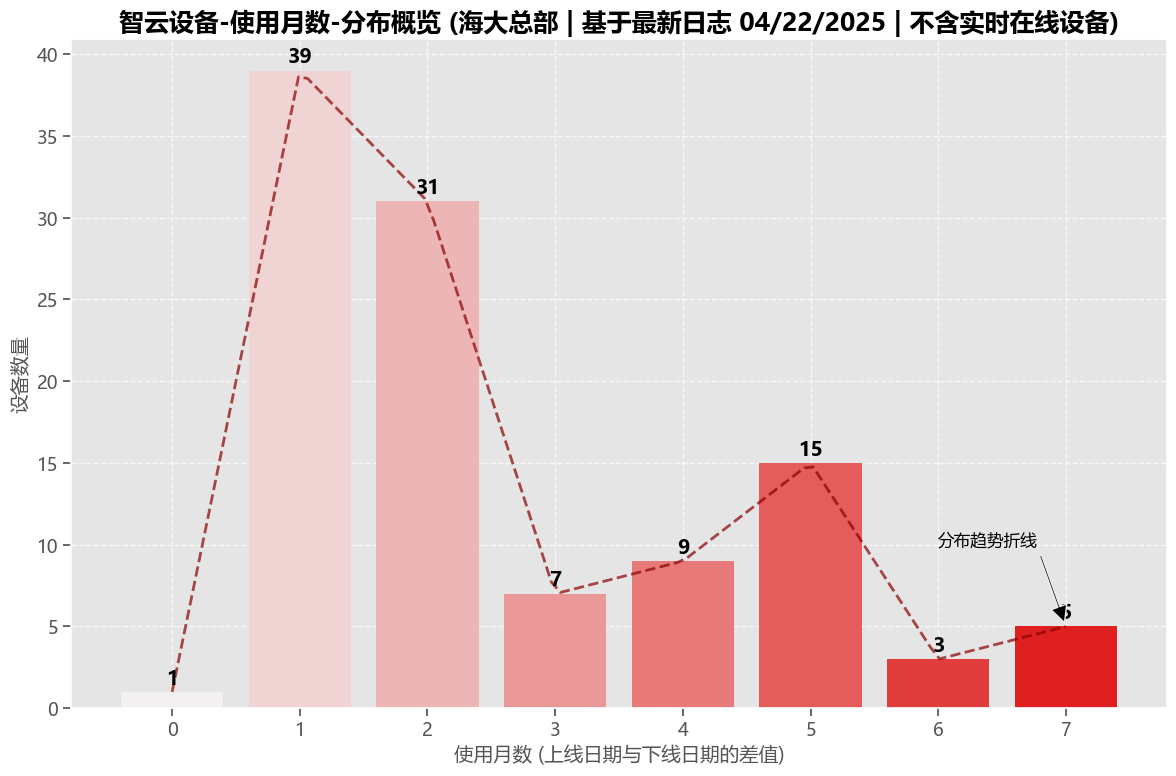

In [ ]:
# Set the style for a professional look
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

# Use SimHei font for Chinese characters
# plt.rcParams['font.sans-serif'] = ['FangSong'] 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# Fix minus sign display 
plt.rcParams['axes.unicode_minus'] = False  

# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Count devices by months_len
months_count = df_ev_haida_data_analysis['months_len'].value_counts().sort_index()

# Create a bar plot with a nice color palette
red_palette = sns.light_palette("red", n_colors=len(months_count), reverse=False)
ax = sns.barplot(
    x=months_count.index, 
    y=months_count.values, 
    hue=months_count.index, 
    palette=red_palette,
    legend=False
)

# Add count labels on top of each bar
for i, count in enumerate(months_count.values):
    ax.text(i, count + 0.5, str(count), ha='center', fontweight='bold')

# Add a trend line to show the distribution pattern
x_smooth = np.linspace(months_count.index.min(), months_count.index.max(), 100)
y_smooth = np.interp(x_smooth, months_count.index, months_count.values)
plt.plot(x_smooth, y_smooth, 'darkred', linestyle='--', linewidth=2, alpha=0.7)

# Customize the plot
plt.title(
    '智云设备-使用月数-分布概览 (海大总部 | 基于最新日志 04/22/2025 | 不含实时在线设备)', 
    fontsize=18, 
    fontweight='bold'
)
plt.xlabel('使用月数 (上线日期与下线日期的差值)', fontsize=14)
plt.ylabel('设备数量', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Add annotations
plt.annotate('分布趋势折线', xy=(x_smooth[-1], y_smooth[-1]), 
             xytext=(x_smooth[-1]-1, y_smooth[-1]+5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=12)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()